## Problem 1: Forecasting

Using historical world trade data from 1946-2016 create a forecasting model with Arima using data from 60% of data for training and 40% for testing. Check for seasonality.







- There is not a test for seasonality with annual data

In [1]:
import sys
!{sys.executable} -m pip install --user pmdarima
!{sys.executable} -m pip install --user lime

In [2]:
# Load the Relevant libraries
import sklearn as sk
import urllib
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import numpy as np
import lime

# URL for the World trade Data (UW Repository)
url = "WorldTrade.csv"
data = pd.read_csv(url)

In [3]:
cols = ['series_type','table_type','table_type_desc','country_type','period_type','period_number',
        'commodity_classification','commodity_group_code','commodity_group_name','trade_flow',
       'partner_country_code','partner_country_english_name','base_year','currency_type',
       'value_unit','value_type','value_type_desc','estimation_type','country_code','period',
       'period_in_date','estimation_type_desc']
data = data.drop(cols,axis='columns')

In [4]:
data.country_english_name.unique()

array(['Australia', 'New Zealand', 'Japan', 'Czechia', 'Colombia',
       'Bulgaria', 'Venezuela (Bolivarian Rep. of)', 'Austria', 'Finland',
       'Greece', 'Estonia', 'Korea, Republic of', 'France', 'Germany',
       'Philippines', 'Portugal', 'Iran (Islamic Rep. of)',
       'United Kingdom', 'Mauritius', 'Singapore', 'Hungary', 'Mexico',
       'Slovakia', 'United States', 'Poland', 'Sweden'], dtype=object)

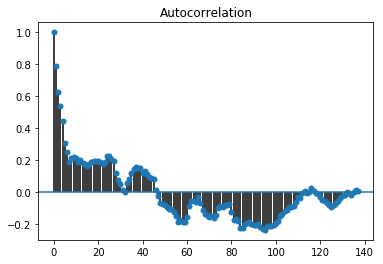

In [5]:
uk = data[data['country_english_name']=='United States']
pm.plot_acf(uk.value)

In [6]:
data.columns

Index(['country_english_name', 'year', 'trade_flow_desc', 'value'], dtype='object')

In [7]:
# create function that takes source data and country of interest as inputs and outputs the train and test sets, and the trained model

def econ_forecast(data,country,flow_type='Exports',split_size=.6):
    # filter trade down to selected type
    data = data[data['trade_flow_desc']==flow_type]
    # filter down to just the one country
    print('Filtering to %s' % (country))
    data = data[data['country_english_name']==country].reset_index()
    print('%d rows of data for %s' % (data.shape[0],country))
    # split data into test and train
    print('Splitting train/test %d/%d' % (split_size*100,(1-split_size)*100))
    l = data.shape[0]
    l = l * split_size
    l = round(l,0)
    l = int(l)
    train = data.iloc[:l]
    test = data.iloc[l:]
    n = len(test)
    print('Training on %d rows of data' % (l))
    # train model
    mod = pm.auto_arima(train['value'],suppress_warnings=True,error_action='ignore')
    print('Model trained \n')
    
    mod.plot_diagnostics(figsize=(7,5))
    plt.show()
    
    print(mod.summary(),'\n')
    
    # Forecast-y section
    n_periods = n
    preds, conf_interval = mod.predict(n_periods=n_periods,return_conf_int=True)
    index_of_fc = np.arange(len(train.value),len(train.value)+n_periods)
    
    fitted_series = pd.Series(preds,index=index_of_fc)
    lower_series = pd.Series(conf_interval[:,0],index=index_of_fc)
    upper_series = pd.Series(conf_interval[:,1],index=index_of_fc)
    
    plt.plot(data.value,label='Actual Values')
    plt.plot(fitted_series,color='darkred',label='Forecasted Values')
#     plt.plot(test.value,color='darkgreen')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k',alpha=.15)
    plt.title('%s Forecast for %d Periods' % (country,n))
    plt.legend()
    plt.show()
    
    yield train
    yield test
    yield mod
    

Filtering to United States
69 rows of data for United States
Splitting train/test 60/40
Training on 41 rows of data
Model trained 



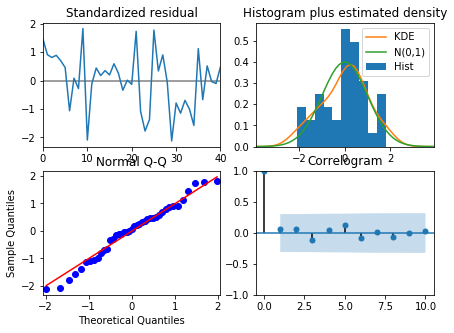

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   41
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -193.748
Date:                Sun, 07 Jul 2019   AIC                            393.496
Time:                        13:46:35   BIC                            398.636
Sample:                             0   HQIC                           395.368
                                 - 41                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     87.9212      6.670     13.181      0.000      74.848     100.994
ma.L1          0.5379      0.134      4.017      0.000       0.275       0.800
sigma2       738.6644    191.750      3.852      0.0

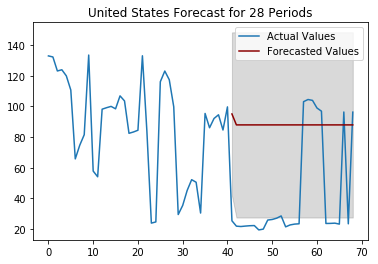

In [8]:
train,test,mod = econ_forecast(data,'United States')

### This function works much better for some countries than for others. For example, this naive function performs very poorly on data from the UK. Additional variables or tuning would be required.

## Problem 2: Ethical Issues

The scoring model based on the dataset described in the ProPubica paper is most certainly biased against the African Americans and other populations. How would you create a system that is less biased against such populations?

There is some value in using these kinds of tools, but more from a descriptive perspective rather than using any predictive funciton. It is useful to gather someone's historical info (the inputs to the model), but there is a lot of context that might not be captured by the model.

As the article states, algorithms should be used to determine sentencing, although they can provide helpful guidance on parole terms.

## Problem 3: Explanations

Using the classifier from any previous assignment extract explanations from 2 positive and 2 negative predictions using the LIME (Locally Interpretable Model agnostic Explanations) model.

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import datasets

iris = datasets.load_iris()

train_x = iris.data[:100]
train_y = iris.target[:100]

test_x = iris.data[100:]
test_y = iris.target[100:]

In [10]:
parameters = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [1, 2, 3], 
    'min_samples_split': [0.05, 0.1, 0.2]
}

dt = DecisionTreeClassifier()
grid = GridSearchCV(dt,parameters,cv=5)
grid.fit(train_x, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3], 'min_samples_split': [0.05, 0.1, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)